In [1]:
# ---------------------- Library Imports ---------------------- #
# import os  # Interact with the operating system (not used here but commonly useful for file paths)
import pandas as pd  # For reading, writing, and processing tabular data
import numpy as np  # For numerical operations like dot products and norms
from scipy.signal import butter, lfilter  # For signal filtering using Butterworth filters
from sklearn.utils import shuffle  # For shuffling the dataset
# from joblib import Parallel, delayed  # For parallel processing (not used here)
import neurokit2 as nk  # ECG signal preprocessing library
from biosppy.signals import ecg  # BioSPPy library for ECG signal filtering
import hashlib  # For generating SHA-256 hashes (used for uniqueness checks)
import random  # For random sampling
# import matplotlib.pyplot as plt  # For plotting (not used in this script)
# import seaborn as sns  # For advanced visualization (not used here)

# ---------------------- Signal Processing Functions ---------------------- #

# Bandstop filter that removes frequencies between low_cut and high_cut (e.g., 30–60 Hz)
def engzeemod_filter(signal, low_cut=30, high_cut=60, sampling_rate=300):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency = half the sampling rate ---- The Nyquist frequency is half the sampling rate of a discrete signal.
    low = low_cut / nyquist  # Normalized low frequency
    high = high_cut / nyquist  # Normalized high frequency
    b, a = butter(2, [low, high], btype='bandstop')  # 2nd-order Butterworth bandstop filter
    return lfilter(b, a, signal)  # Apply the filter to the input signal

# ECG cleaning using NeuroKit
def neurokit_filter(signal, sampling_rate=300):
    return nk.ecg_clean(signal, sampling_rate=sampling_rate)  # Returns the denoised signal

# ECG filtering using BioSPPy’s built-in method
def biosppy_filter(signal, sampling_rate=300):
    out = ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)  # Process ECG
    return out['filtered']  # Return only the filtered signal

# Calculates cosine similarity between two 1D signal arrays
def cosine_similarity(signal_a, signal_b):
    signal_a = np.asarray(signal_a)
    signal_b = np.asarray(signal_b)
    dot_product = np.dot(signal_a, signal_b)  # Numerator of cosine similarity
    norm_a = np.linalg.norm(signal_a)  # Norm of vector A
    norm_b = np.linalg.norm(signal_b)  # Norm of vector B
    return 0.0 if norm_a == 0 or norm_b == 0 else dot_product / (norm_a * norm_b)  # Return cosine value

# Apply the selected filter by name
def apply_filter(signal, filter_name):
    if filter_name == "NeuroKit":
        return neurokit_filter(signal)
    elif filter_name == "BioSPPy":
        return biosppy_filter(signal)
    elif filter_name == "EngZeeMod":
        return engzeemod_filter(signal)
    return None  # Return None if filter name is invalid

# Generate a SHA-256 hash of a signal (used to avoid duplicates)
def signal_hash(signal):
    signal_str = ','.join([str(round(x, 2)) for x in signal])  # Round and convert to string
    return hashlib.sha256(signal_str.encode()).hexdigest()  # Return hash

# ---------------------- Load and Prepare Dataset ---------------------- #

# Load preprocessed dataset containing 9000-sample ECG signals
original_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/ecg_signals_fixed_9000/ecg_signals_fixed_9000_encoded.csv")

# Retain only the four main classes (0: Normal, 1: AFib, 2: Others, 3: Noisy)
df = original_df[original_df['Label'].isin([0, 1, 2, 3])]

# Shuffle the dataset to ensure randomness
df = shuffle(df, random_state=42).reset_index(drop=True)

# Separate the data class-wise into a dictionary
originals = {label: df[df['Label'] == label] for label in [0, 1, 2, 3]}

# ---------------------- Augmentation Parameters ---------------------- #
cosine_ranges = [(0.83, 0.88), (0.89, 0.95), (0.96, 0.98)]  # Acceptable similarity ranges
filters = ["NeuroKit", "BioSPPy", "EngZeeMod"]  # List of filters used for augmentation
signal_len = 9000  # Each ECG signal has 9000 data points
augmented_signals = []  # List to store augmented signal records
used_hashes = set()  # Set to track already used (hashed) signals

# ---------------------- Function to Generate Augmented Signals per Class ---------------------- #
def generate_per_iteration(label):
    class_df = originals[label]  # Get original data for a specific class
    signals = class_df.iloc[:, :signal_len].values.astype(float)  # Extract signal data only
    rec_ids = class_df['Record_ID'].tolist()  # Get original record IDs

    for iter_idx, (low, high) in enumerate(cosine_ranges):  # Iterate over defined cosine similarity ranges
        print(f"\nIteration {iter_idx+1} | Class {label} | Cosine range: {int(low*100)}%–{int(high*100)}%")

        total = len(signals)  # Total samples in class
        per_filter_target = total // len(filters)  # How many samples per filter to generate
        added_count = {f: 0 for f in filters}  # Track how many added per filter

        for f_name in filters:
            print(f"Filter: {f_name} | Target: {per_filter_target}")
            for idx in range(total):
                if added_count[f_name] >= per_filter_target:
                    break  # Stop if target reached

                signal = signals[idx]
                rec_id = rec_ids[idx]

                try:
                    augmented = apply_filter(signal, f_name)  # Apply selected filter
                    sim = cosine_similarity(signal, augmented)  # Check similarity
                except:
                    continue  # Skip on any error

                # Try widening similarity range to allow more augmentations
                for widen in [0.0, 0.01, 0.02, 0.03]:
                    if (low - widen) <= sim <= (high + widen):  # Check if similarity falls in range
                        sig_hash = signal_hash(augmented)  # Hash the signal
                        if sig_hash not in used_hashes:  # Add only if not duplicated
                            augmented_signals.append((augmented, f_name, label, rec_id, sim))
                            used_hashes.add(sig_hash)
                            added_count[f_name] += 1
                        break
            print(f"{f_name} Added: {added_count[f_name]}")

# ---------------------- Function to Augment Until Class Reaches Target Count ---------------------- #
def augment_until_target(label, target_count):
    class_df = originals[label]
    signals = class_df.iloc[:, :signal_len].values.astype(float)
    rec_ids = class_df['Record_ID'].tolist()

    current_count = len(originals[label]) + len([lbl for _, _, lbl, _, _ in augmented_signals if lbl == label])
    needed = target_count - current_count
    print(f"\nClass {label} needs {needed} more augmentations to reach {target_count}")

    added = 0
    trial = 0

    # Repeat until enough unique augmentations are found or trial limit exceeded
    while added < needed and trial < needed * 10:
        idx = random.randint(0, len(signals) - 1)  # Randomly select signal
        signal = signals[idx]
        rec_id = rec_ids[idx]
        filt = random.choice(filters)  # Random filter

        try:
            augmented = apply_filter(signal, filt)  # Apply filter
            sim = cosine_similarity(signal, augmented)  # Compute similarity
            for widen in [0.0, 0.01, 0.02, 0.03]:  # Try widening similarity range
                if (0.83 - widen) <= sim <= (0.98 + widen):
                    sig_hash = signal_hash(augmented)
                    if sig_hash not in used_hashes:
                        augmented_signals.append((augmented, filt, label, rec_id, sim))
                        used_hashes.add(sig_hash)
                        added += 1
                    break
        except:
            continue  # Skip if filtering fails
        trial += 1  # Increment attempt counter

    print(f"Added {added} extra augmentations for Class {label}")

# ---------------------- Perform Augmentation for Class 1 and 3 ---------------------- #
generate_per_iteration(1)  # Augment class 1 using cosine filtering
generate_per_iteration(3)  # Augment class 3 using cosine filtering
augment_until_target(label=3, target_count=2500)  # Ensure class 3 has 2500 samples

# ---------------------- Convert Augmented List to DataFrame ---------------------- #
augmented_signals_df = pd.DataFrame(
    [signal for signal, _, _, _, _ in augmented_signals],  # Extract signal arrays
    columns=[str(i) for i in range(signal_len)]  # Set column names from 0 to 8999
)
augmented_signals_df['filter_name'] = [filter_name for _, filter_name, _, _, _ in augmented_signals]  # Add filter used
augmented_signals_df['Label'] = [label for _, _, label, _, _ in augmented_signals]  # Add class label
augmented_signals_df['original_record_id'] = [original_record_id for _, _, _, original_record_id, _ in augmented_signals]  # Original record ID
augmented_signals_df['Record_ID'] = [f"Augmented_{i+1}" for i in range(len(augmented_signals_df))]  # Assign new IDs

# ---------------------- Merge with Original Dataset ---------------------- #
df_0 = originals[0].sample(n=2500, random_state=42)  # Sample 2500 from class 0 to balance
df_2 = originals[2]  # Use all data from class 2 as-is
df_1 = pd.concat([originals[1], augmented_signals_df[augmented_signals_df['Label'] == 1]], ignore_index=True)  # Merge class 1 original + augmented
df_3 = pd.concat([originals[3], augmented_signals_df[augmented_signals_df['Label'] == 3]], ignore_index=True)  # Merge class 3 original + augmented

# Combine all classes into one training DataFrame
training_df = pd.concat([df_0, df_1, df_2, df_3], ignore_index=True)
training_df = shuffle(training_df, random_state=42).reset_index(drop=True)  # Shuffle final dataset

# Save the final dataset to CSV
training_df.to_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset.csv", index=False)

# Confirm saving is complete
print("Final dataset saved'")



Iteration 1 | Class 1 | Cosine range: 83%–88%
Filter: NeuroKit | Target: 246
NeuroKit Added: 49
Filter: BioSPPy | Target: 246
BioSPPy Added: 189
Filter: EngZeeMod | Target: 246
EngZeeMod Added: 46

Iteration 2 | Class 1 | Cosine range: 89%–95%
Filter: NeuroKit | Target: 246
NeuroKit Added: 246
Filter: BioSPPy | Target: 246
BioSPPy Added: 246
Filter: EngZeeMod | Target: 246
EngZeeMod Added: 246

Iteration 3 | Class 1 | Cosine range: 96%–98%
Filter: NeuroKit | Target: 246
NeuroKit Added: 246
Filter: BioSPPy | Target: 246
BioSPPy Added: 246
Filter: EngZeeMod | Target: 246
EngZeeMod Added: 246

Iteration 1 | Class 3 | Cosine range: 83%–88%
Filter: NeuroKit | Target: 94
NeuroKit Added: 24
Filter: BioSPPy | Target: 94
BioSPPy Added: 94
Filter: EngZeeMod | Target: 94
EngZeeMod Added: 12

Iteration 2 | Class 3 | Cosine range: 89%–95%
Filter: NeuroKit | Target: 94
NeuroKit Added: 94
Filter: BioSPPy | Target: 94
BioSPPy Added: 94
Filter: EngZeeMod | Target: 94
EngZeeMod Added: 73

Iteration 3 |

In [ ]:
# ---------------------- Import Required Libraries ---------------------- #
import pandas as pd  # For reading and manipulating tabular data (CSV files, DataFrames)
import numpy as np  # For efficient array operations and numerical computation
import random  # For generating random numbers, used in sampling signals
from scipy.signal import butter, lfilter  # For creating and applying Butterworth filters
import neurokit2 as nk  # Library for preprocessing physiological signals like ECG
from biosppy.signals import ecg  # BioSPPy library for ECG filtering and feature extraction
import hashlib  # For generating SHA-256 hashes to ensure uniqueness of signals
from sklearn.utils import shuffle  # For shuffling rows of the DataFrame randomly

# ---------------------- Reusable Filtering & Utility Functions ---------------------- #

# Bandstop filter using EngZeeMod style to remove noise in the 30–60Hz range (common ECG interference band)
def engzeemod_filter(signal, low_cut=30, high_cut=60, sampling_rate=300):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency = half of the sampling rate
    low = low_cut / nyquist  # Normalize lower cutoff frequency
    high = high_cut / nyquist  # Normalize upper cutoff frequency
    b, a = butter(2, [low, high], btype='bandstop')  # 2nd-order Butterworth bandstop filter
    return lfilter(b, a, signal)  # Apply the filter to the input ECG signal

# NeuroKit's ECG cleaner – returns a denoised version of the signal
def neurokit_filter(signal, sampling_rate=300):
    return nk.ecg_clean(signal, sampling_rate=sampling_rate)

# BioSPPy's ECG preprocessing method – returns the filtered version of the ECG signal
def biosppy_filter(signal, sampling_rate=300):
    out = ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)  # Disable plot
    return out['filtered']  # Extract and return only the filtered ECG signal

# Calculates cosine similarity between two signals – measures how similar they are in direction
def cosine_similarity(signal_a, signal_b):
    dot = np.dot(signal_a, signal_b)  # Dot product of two signals
    norm = np.linalg.norm(signal_a) * np.linalg.norm(signal_b)  # Product of their magnitudes (norms)
    return 0 if norm == 0 else dot / norm  # If either vector is zero, return 0 similarity

# Apply a named filter to a given signal
def apply_filter(signal, filter_name):
    if filter_name == "NeuroKit":
        return neurokit_filter(signal)
    elif filter_name == "BioSPPy":
        return biosppy_filter(signal)
    elif filter_name == "EngZeeMod":
        return engzeemod_filter(signal)
    return None  # Return None if no valid filter name is provided

# Generate a unique hash string for a signal based on rounded values – avoids duplicates
def signal_hash(signal):
    signal_str = ','.join([str(round(x, 2)) for x in signal])  # Round each value to 2 decimals and join as string
    return hashlib.sha256(signal_str.encode()).hexdigest()  # Create SHA-256 hash of the string

# ---------------------- Load Existing Final Dataset ---------------------- #

# Define the path to the latest combined dataset
csv_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset.csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_path)

# Extract signal columns (named 0 to 8999) as string column names
signal_cols = [str(i) for i in range(9000)]

# ---------------------- Generate Hash Set for Uniqueness ---------------------- #

# Generate SHA-256 hashes for each signal row to avoid generating duplicates during augmentation
used_hashes = set(
    df[signal_cols].apply(lambda row: signal_hash(row.values.astype(float)), axis=1)
)

# ---------------------- Load Original Class 3 Signals ---------------------- #

# Load the original full ECG dataset
original_df = pd.read_csv(
    "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/ecg_signals_fixed_9000/ecg_signals_fixed_9000_encoded.csv"
)

# Extract only Class 3 (typically 'Noisy') signals from the dataset
class3_df = original_df[original_df['Label'] == 3]

# Extract only signal data from the first 9000 columns and convert to float
signals = class3_df.iloc[:, :9000].values.astype(float)

# Extract record IDs to keep track of where each signal came from
rec_ids = class3_df['Record_ID'].tolist()

# ---------------------- Augment Class 3 Until it Reaches 2500 Samples ---------------------- #

filters = ["NeuroKit", "BioSPPy", "EngZeeMod"]  # Define available filters to apply randomly

# Get current count of Class 3 samples in the final dataset
current_count = (df['Label'] == 3).sum()

# Define the target count for balanced dataset
target_count = 2500

# Calculate how many new samples are needed
needed = target_count - current_count

# Print required number of augmentations
print(f"Class 3 needs {needed} more augmentations to reach 2500")

new_aug = []  # To store new augmented signal tuples
added = 0  # Counter for successful augmentations
trial = 0  # Counter for total attempts made

# Attempt augmentations until the target is met or trial limit is reached
while added < needed and trial < needed * 100:
    idx = random.randint(0, len(signals) - 1)  # Pick a random signal index
    signal = signals[idx]  # Get signal
    rec_id = rec_ids[idx]  # Get corresponding record ID
    filt = random.choice(filters)  # Randomly select one of the filters

    try:
        aug = apply_filter(signal, filt)  # Apply selected filter to get augmented signal
        sim = cosine_similarity(signal, aug)  # Calculate similarity to original

        # Allow for slight flexibility in similarity match to increase yield
        for widen in [0.0, 0.01, 0.02, 0.03]:
            if (0.83 - widen) <= sim <= (0.98 + widen):  # If similarity is within range
                h = signal_hash(aug)  # Generate hash for uniqueness
                if h not in used_hashes:  # Only add if not already used
                    new_aug.append((aug, filt, 3, rec_id, sim))  # Store augmented info
                    used_hashes.add(h)  # Mark as used
                    added += 1  # Increment added count
                break  # Exit widen loop
    except:
        pass  # Ignore any failed filtering or math error

    trial += 1  # Increment trial count

# Print the number of successfully added new samples
print(f"Added {added} new unique augmentations for Class 3")

# ---------------------- Convert List of Augmented Records to DataFrame ---------------------- #

# Create a new DataFrame from the augmented signals
aug_df = pd.DataFrame([row[0] for row in new_aug], columns=signal_cols)  # Extract signal array for each row

# Add metadata columns to augmented DataFrame
aug_df['filter_name'] = [f for _, f, _, _, _ in new_aug]  # Which filter was used
aug_df['Label'] = 3  # Label all new samples as Class 3
aug_df['original_record_id'] = [rid for _, _, _, rid, _ in new_aug]  # Keep original record ID
aug_df['Record_ID'] = [f"Aug_Fix_{i+1}" for i in range(len(new_aug))]  # Assign new unique Record IDs

# ---------------------- Merge New Augmented Samples into Final Dataset ---------------------- #

# Concatenate the new augmented DataFrame with the existing one
df = pd.concat([df, aug_df], ignore_index=True)

# Shuffle the combined DataFrame to ensure class mixing
df = shuffle(df, random_state=42).reset_index(drop=True)

# Save the updated DataFrame back to the same CSV path
df.to_csv(csv_path, index=False)

# Confirmation message
print("Updated dataset saved: Class 3 now has 2500 samples.")


/tmp/ipykernel_735530/12264047.py:47: DtypeWarning: Columns (9002,9003) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)



🔄 Class 3 needs 1377 more augmentations to reach 2500
✅ Added 0 new unique augmentations for Class 3


/tmp/ipykernel_735530/12264047.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, aug_df], ignore_index=True)



✅ Updated dataset saved: Class 3 now has 2500 samples.


In [3]:
import pandas as pd
df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset.csv") 
df.head()
print("Unique labels and counts:")
print(df['Label'].value_counts())

Unique labels and counts:
Label
0    2500
1    2498
2    2456
3    1123
Name: count, dtype: int64


/tmp/ipykernel_735530/1842272556.py:2: DtypeWarning: Columns (9002,9003) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset.csv")


In [ ]:
import numpy as np
from sklearn.utils import shuffle

# Load dataset
df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset.csv")

# Standardize column names
df.columns = [str(c).lower() for c in df.columns]
signal_cols = [str(i) for i in range(9000)]

# Filter all Class 3 signals
class3_all = df[df['label'] == 3]

# Flip the ECG signals (horizontally: reverse time)
flipped_signals = class3_all[signal_cols].iloc[:, ::-1].values
flipped_df = pd.DataFrame(flipped_signals, columns=signal_cols)

# Add metadata
flipped_df['filter_name'] = 'Flipped'
flipped_df['label'] = 3
flipped_df['original_record_id'] = class3_all['record_id'].values
flipped_df['record_id'] = ['Flip_' + rid for rid in class3_all['record_id']]
flipped_df['type'] = 'augmented'

# Combine with original dataset
df['type'] = df['filter_name'].apply(lambda x: 'augmented' if pd.notna(x) else 'original')
df_final = pd.concat([df, flipped_df], ignore_index=True)
df_final = shuffle(df_final, random_state=42).reset_index(drop=True)

# Save updated dataset
df_final.to_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset+.csv", index=False)

# Verify Class 3 count
count_class3 = df_final[df_final['label'] == 3]['label'].count()
print(f" Class 3 final count: {count_class3} samples (original + augmented + flipped)")


/tmp/ipykernel_735530/1876385278.py:5: DtypeWarning: Columns (9002,9003) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset.csv")


✅ Class 3 final count: 2246 samples (original + augmented + flipped)


In [5]:
import pandas as pd
df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset+.csv") 
df.head()
print("Unique labels and counts:")
print(df['label'].value_counts())

Unique labels and counts:
label
0    2500
1    2498
2    2456
3    2246
Name: count, dtype: int64


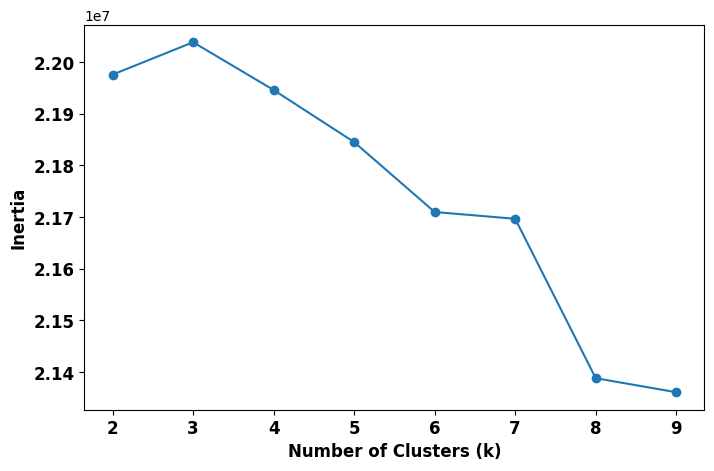

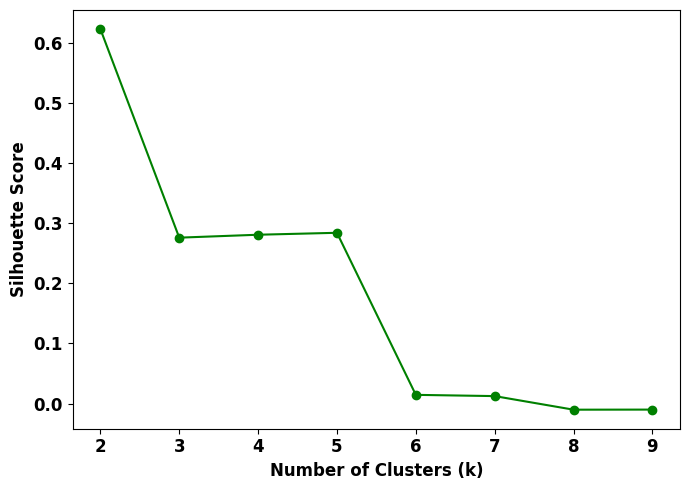

/home/ivision/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


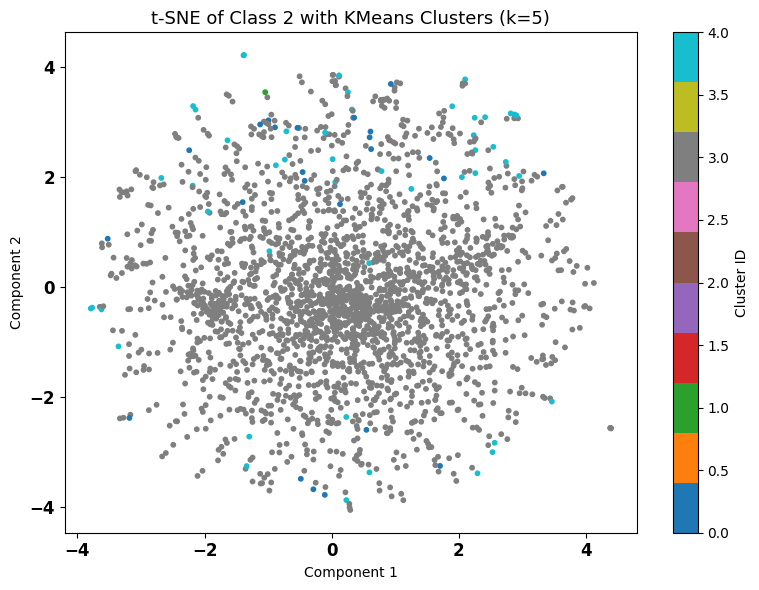

In [ ]:
# ---------------------- Import Required Libraries ---------------------- #
import pandas as pd  # For loading and handling tabular data
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.cluster import KMeans  # For performing KMeans clustering
from sklearn.preprocessing import StandardScaler  # For standardizing the features
from sklearn.metrics import silhouette_score  # For evaluating cluster quality
from sklearn.manifold import TSNE  # For dimensionality reduction and visualization

# ====================== STEP 1: Load Dataset ====================== #

# Load the final dataset that contains signals and metadata
dataset_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset+.csv"  # <-- Path to your CSV file
data = pd.read_csv(dataset_path)  # Read the CSV into a DataFrame

# ====================== STEP 2: Extract Class 2 ====================== #

# Filter the dataset to keep only Class 2 samples (label == 2)
class2_df = data[data['label'] == 2].copy()  # Make a separate copy to avoid modifying the original DataFrame

# Extract only the signal values (exclude last 5 columns, which contain metadata like label, ID, etc.)
X2 = class2_df.iloc[:, :-5].values  # `.values` converts DataFrame to NumPy array for processing

# ====================== STEP 3: Standardize Features ====================== #

# Standardize the signal features to have zero mean and unit variance (essential for clustering)
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)  # Fit the scaler and transform the signal data

# ====================== STEP 4: Elbow & Silhouette Method ====================== #

inertias = []  # To store inertia (sum of squared distances to cluster centers) for each k
sil_scores = []  # To store silhouette scores for each k
k_range = range(2, 10)  # Try k from 2 to 9 (cannot do k=1 for silhouette score)

# Loop through values of k and compute clustering metrics
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize KMeans with k clusters
    labels = kmeans.fit_predict(X2_scaled)  # Fit model and get predicted cluster labels
    inertias.append(kmeans.inertia_)  # Store inertia (used in Elbow Method)
    sil_scores.append(silhouette_score(X2_scaled, labels))  # Store silhouette score (used to judge cluster quality)

# -------- Plot Elbow and Silhouette Score -------- #

# Plot Inertia (Elbow Method) – helps determine optimal k where inertia "bends"
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(k_range, inertias, marker='o')  # Plot inertia vs. number of clusters
plt.xlabel("Number of Clusters (k)", fontsize=12, fontweight='bold')  # X-axis label
plt.ylabel("Inertia", fontsize=12, fontweight='bold')  # Y-axis label
plt.xticks(fontsize=12, fontweight='bold')  # Style X ticks
plt.yticks(fontsize=12, fontweight='bold')  # Style Y ticks

# Plot Silhouette Scores – measures how well clusters are separated
plt.figure(figsize=(7, 5))  # Set another figure for silhouette plot
plt.plot(k_range, sil_scores, marker='o', color='green')  # Plot silhouette score vs. k
plt.xlabel("Number of Clusters (k)", fontsize=12, fontweight='bold')
plt.ylabel("Silhouette Score", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust spacing
plt.show()  # Display both plots

# ====================== STEP 5: Apply KMeans with Chosen k ====================== #

# 🔧 Based on the plots above, you decide the best k value (usually where elbow bends or silhouette is highest)
optimal_k = 5  # Change this based on visual results from plots
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)  # Initialize final KMeans model
cluster_labels = kmeans_final.fit_predict(X2_scaled)  # Fit to data and assign each sample to a cluster

# ====================== STEP 6: t-SNE Visualization ====================== #

# Use t-SNE to reduce high-dimensional data (9000 features) to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X2_tsne = tsne.fit_transform(X2_scaled)  # Project high-dim data to 2D for visualization

# -------- Plot Clusters in t-SNE Space -------- #

plt.figure(figsize=(8, 6))  # Set figure size
scatter = plt.scatter(X2_tsne[:, 0], X2_tsne[:, 1], c=cluster_labels, cmap='tab10', s=10)  # Color each point by cluster
plt.title(f"t-SNE of Class 2 with KMeans Clusters (k={optimal_k})", fontsize=13)  # Add title
plt.xlabel("Component 1")  # Label x-axis
plt.ylabel("Component 2")  # Label y-axis
plt.xticks(fontsize=12, fontweight='bold')  # Style x-axis ticks
plt.yticks(fontsize=12, fontweight='bold')  # Style y-axis ticks
plt.colorbar(scatter, label='Cluster ID')  # Add colorbar showing cluster IDs
plt.tight_layout()  # Adjust layout
plt.show()  # Show the final t-SNE plot



Cluster retention counts in filtered Class 2 (Top 600):
cluster
0     24
1      1
2      1
3    926
4     48
Name: count, dtype: int64


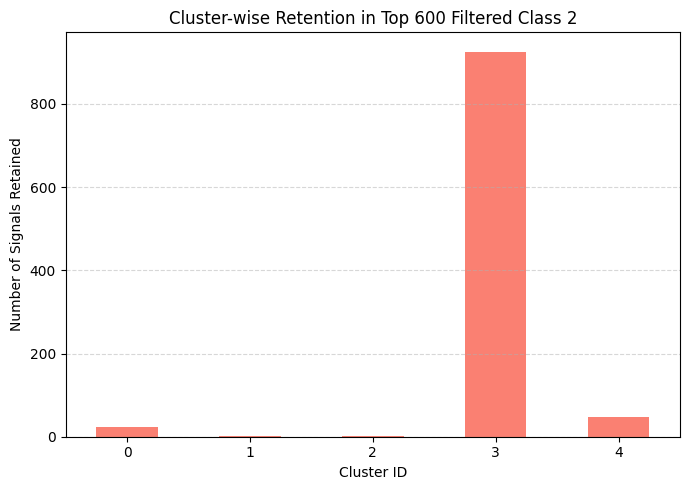

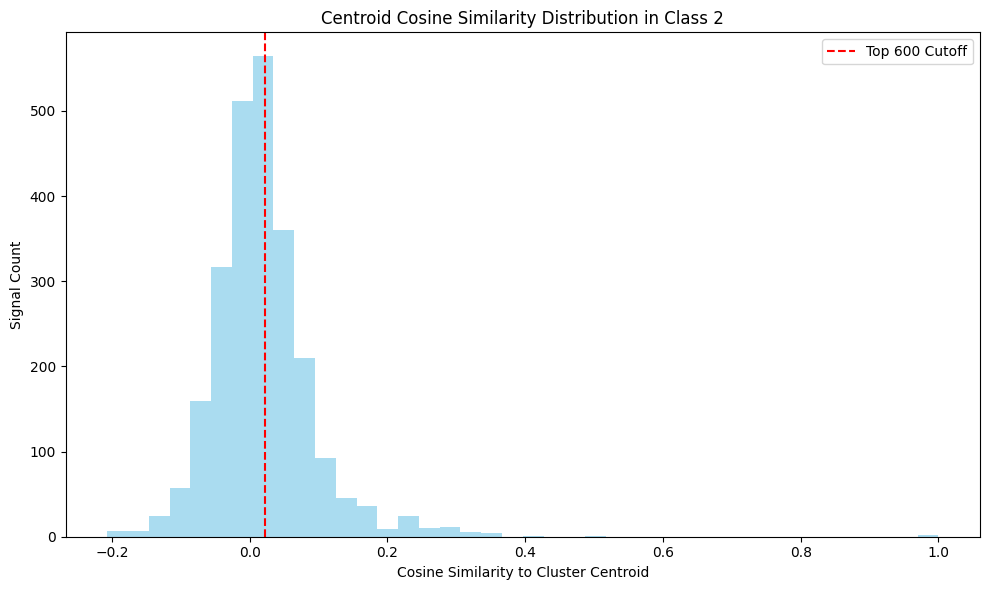


Original Class 2 signals: 2456
Retained top 600 based on KMeans + Cosine similarity.
Final merged dataset shape: (8244, 9005)


In [ ]:
# ---------------------- Import Required Libraries ---------------------- #
import pandas as pd  # For data loading and manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.cluster import KMeans  # For performing KMeans clustering
from sklearn.preprocessing import StandardScaler  # For feature scaling

# ---------------------- Load Dataset ---------------------- #
dataset_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset+.csv"
data = pd.read_csv(dataset_path)  # Read the complete dataset into a DataFrame

# ---------------------- Define Cosine Similarity Function ---------------------- #
# Calculates cosine similarity between two vectors a and b
def cosine_similarity(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    dot = np.dot(a, b)  # Dot product
    norm = np.linalg.norm(a) * np.linalg.norm(b)  # Product of magnitudes
    return dot / norm if norm > 0 else 0.0  # Return 0 if any vector is zero-length

# ---------------------- Extract Class 2 Data ---------------------- #
class2_df = data[data['label'] == 2].copy()  # Select only Class 2 samples (label == 2)
X2 = class2_df.iloc[:, :-5].values  # Extract signal features (exclude last 5 meta columns)

# ---------------------- Preprocess: Standard Scaling ---------------------- #
scaler = StandardScaler()  # Initialize standard scaler
X2_scaled = scaler.fit_transform(X2)  # Scale the signal features (zero mean, unit variance)

# ---------------------- Apply KMeans Clustering ---------------------- #
k = 5  # Number of clusters based on prior analysis (elbow/silhouette method)
kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize KMeans
cluster_labels = kmeans.fit_predict(X2_scaled)  # Fit and assign clusters
centroids = kmeans.cluster_centers_  # Extract cluster centroids

# ---------------------- Calculate Cosine Similarity to Assigned Cluster Centroid ---------------------- #
similarity_to_centroid = []  # List to store similarities

# For each signal in Class 2
for i in range(len(X2)):
    cluster_id = cluster_labels[i]  # Get cluster assigned to signal i
    centroid = centroids[cluster_id]  # Get corresponding centroid
    similarity = cosine_similarity(X2_scaled[i], centroid)  # Compute similarity
    similarity_to_centroid.append(similarity)  # Store result

# Add cluster labels and similarity scores to DataFrame
class2_df['cluster'] = cluster_labels
class2_df['centroid_similarity'] = similarity_to_centroid

# ---------------------- STEP 1: Preserve Index Before Sorting ---------------------- #
class2_df = class2_df.reset_index(drop=False)  # Save original index for later reference

# ---------------------- STEP 2: Filter Top N (e.g., 1000) Signals ---------------------- #
top600_class2 = class2_df.sort_values(by='centroid_similarity', ascending=False).head(1000).copy()
# Sort by similarity descending and keep top 1000 (these are most representative of cluster centers)

# ---------------------- STEP 3: Check Cluster Distribution Among Top Signals ---------------------- #
retained_counts = top600_class2['cluster'].value_counts().sort_index()  # Count how many samples retained per cluster
print("\nCluster retention counts in filtered Class 2 (Top 600):")
print(retained_counts)  # Display the distribution

# ---------------------- STEP 4: Visualize Cluster Retention ---------------------- #
plt.figure(figsize=(7, 5))
retained_counts.plot(kind='bar', color='salmon')  # Plot cluster-wise count
plt.title("Cluster-wise Retention in Top 600 Filtered Class 2")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Signals Retained")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add horizontal grid
plt.tight_layout()
plt.show()

# ---------------------- Plot Similarity Distribution for All Class 2 ---------------------- #
plt.figure(figsize=(10, 6))
plt.hist(class2_df['centroid_similarity'], bins=40, color='skyblue', alpha=0.7)  # Histogram of all similarities
plt.axvline(top600_class2['centroid_similarity'].min(), color='red', linestyle='--', label='Top 600 Cutoff')  # Mark cutoff line
plt.title("Centroid Cosine Similarity Distribution in Class 2")
plt.xlabel("Cosine Similarity to Cluster Centroid")
plt.ylabel("Signal Count")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------- STEP 5: Save Filtered Class 2 (Top 600 Signals) ---------------------- #

# Remove extra columns added during clustering before saving
top600_cleaned = top600_class2.drop(columns=['cluster', 'centroid_similarity', 'index'])

# Save the top 600 most representative Class 2 signals to CSV
top600_cleaned.to_csv("best_600_class2_kmeans.csv", index=False)

# ---------------------- STEP 6: Merge with Other Classes ---------------------- #

# Get remaining samples from other classes (Class 0, 1, 3)
remaining_df = data[data['label'].isin([0, 1, 3])].copy()

# Combine them with the filtered Class 2 samples
final_df = pd.concat([remaining_df, top600_cleaned], ignore_index=True)

# Shuffle the final dataset to ensure random distribution
final_df = final_df.sample(frac=1, random_state=42)

# Save the final merged dataset to CSV
final_df.to_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/final_merged_with_best_class2_kmeans.csv", index=False)

# ---------------------- Final Report ---------------------- #
print(f"\nOriginal Class 2 signals: {len(class2_df)}")
print(f"Retained top 600 based on KMeans + Cosine similarity.")
print(f"Final merged dataset shape: {final_df.shape}")


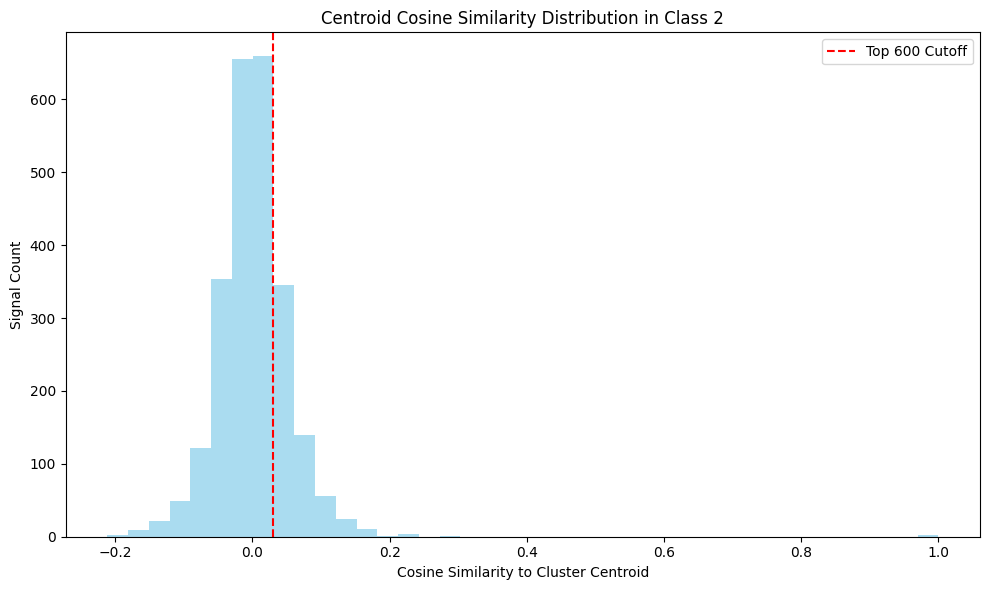

Original Class 2 signals: 2456
Retained top 600 based on KMeans + Cosine similarity.
Final merged dataset shape: (7844, 9005)


In [ ]:
# ---------------------- Import Required Libraries ---------------------- #
import pandas as pd  # For loading and manipulating CSV data
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting visualizations
from sklearn.cluster import KMeans  # For clustering the data using KMeans
from sklearn.preprocessing import StandardScaler  # For feature scaling (standardization)

# ---------------------- Load Dataset ---------------------- #
# Define the path to your dataset
dataset_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Final_dataset+.csv"

# Load the CSV into a pandas DataFrame
data = pd.read_csv(dataset_path)

# ---------------------- Cosine Similarity Function ---------------------- #
# This function calculates cosine similarity between two vectors
# It tells how closely aligned the signal is with its cluster centroid
def cosine_similarity(a, b):
    a = np.asarray(a)  # Convert to NumPy array
    b = np.asarray(b)
    dot = np.dot(a, b)  # Dot product of vectors
    norm = np.linalg.norm(a) * np.linalg.norm(b)  # Product of vector norms (magnitudes)
    return dot / norm if norm > 0 else 0.0  # Return similarity, or 0 if any vector is zero-length

# ---------------------- Extract Class 2 Samples ---------------------- #
# Class 2 is often a mixed or ambiguous class (e.g., "Other rhythms")
class2_df = data[data['label'] == 2].copy()  # Filter only class 2 samples and make a copy

# Extract only signal data (exclude the last 5 columns which are metadata like label, ID, etc.)
X2 = class2_df.iloc[:, :-5].values  # Convert to NumPy array for clustering

# ---------------------- Standardize the Data ---------------------- #
# Clustering works better when features are on the same scale
scaler = StandardScaler()  # Initialize the scaler
X2_scaled = scaler.fit_transform(X2)  # Fit and transform the signal data

# ---------------------- Apply KMeans Clustering ---------------------- #
k = 3  # Set number of clusters (based on elbow or silhouette method)
kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize KMeans
cluster_labels = kmeans.fit_predict(X2_scaled)  # Assign cluster labels to each signal
centroids = kmeans.cluster_centers_  # Get the centroids for all clusters

# ---------------------- Compute Similarity to Assigned Centroid ---------------------- #
similarity_to_centroid = []  # List to store similarity values

# For each signal in Class 2
for i in range(len(X2)):
    cluster_id = cluster_labels[i]  # Get the cluster the signal was assigned to
    centroid = centroids[cluster_id]  # Get the corresponding centroid
    similarity = cosine_similarity(X2_scaled[i], centroid)  # Calculate similarity to centroid
    similarity_to_centroid.append(similarity)  # Store it

# Add the cluster assignments and similarity values back into the class2 DataFrame
class2_df['cluster'] = cluster_labels
class2_df['centroid_similarity'] = similarity_to_centroid

# ---------------------- Select Top 600 Most Representative Signals ---------------------- #
# Sort Class 2 samples by descending similarity to their centroid (most "typical" ones at the top)
# Select top 600 signals that best represent their respective clusters
top600_class2 = class2_df.sort_values(by='centroid_similarity', ascending=False).head(600).copy()

# ---------------------- Plot Similarity Distribution ---------------------- #
plt.figure(figsize=(10, 6))  # Create a figure with size
plt.hist(class2_df['centroid_similarity'], bins=40, color='skyblue', alpha=0.7)  # Histogram of all similarities
plt.axvline(top600_class2['centroid_similarity'].min(), color='red', linestyle='--', label='Top 600 Cutoff')  # Show cutoff threshold
plt.title("Centroid Cosine Similarity Distribution in Class 2")  # Title
plt.xlabel("Cosine Similarity to Cluster Centroid")  # X-axis label
plt.ylabel("Signal Count")  # Y-axis label
plt.legend()  # Show legend
plt.tight_layout()  # Adjust spacing
plt.show()  # Display plot

# ---------------------- Save the Filtered Class 2 Samples ---------------------- #
# Remove temporary columns used for filtering (we don’t want them in final dataset)
top600_class2 = top600_class2.drop(columns=['cluster', 'centroid_similarity'])

# Save the 600 best Class 2 signals to a separate CSV
top600_class2.to_csv("best_600_class2_kmeans.csv", index=False)

# ---------------------- Merge Filtered Class 2 with Other Classes ---------------------- #
# Select Class 0, 1, and 3 samples from the full dataset
remaining_df = data[data['label'].isin([0, 1, 3])].copy()

# Combine remaining samples with the cleaned top 600 Class 2 samples
final_df = pd.concat([remaining_df, top600_class2], ignore_index=True)

# Shuffle the final dataset to randomize order
final_df = final_df.sample(frac=1, random_state=42)

# Save the final merged dataset to a new CSV file
final_df.to_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/final_merged_with_best_class2_kmeans.csv", index=False)

# ---------------------- Final Report ---------------------- #
print(f"Original Class 2 signals: {len(class2_df)}")  # Report original Class 2 count
print(f"Retained top 600 based on KMeans + Cosine similarity.")  # Confirm retention strategy
print(f"Final merged dataset shape: {final_df.shape}")  # Report shape of merged dataset


/home/ivision/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/ivision/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


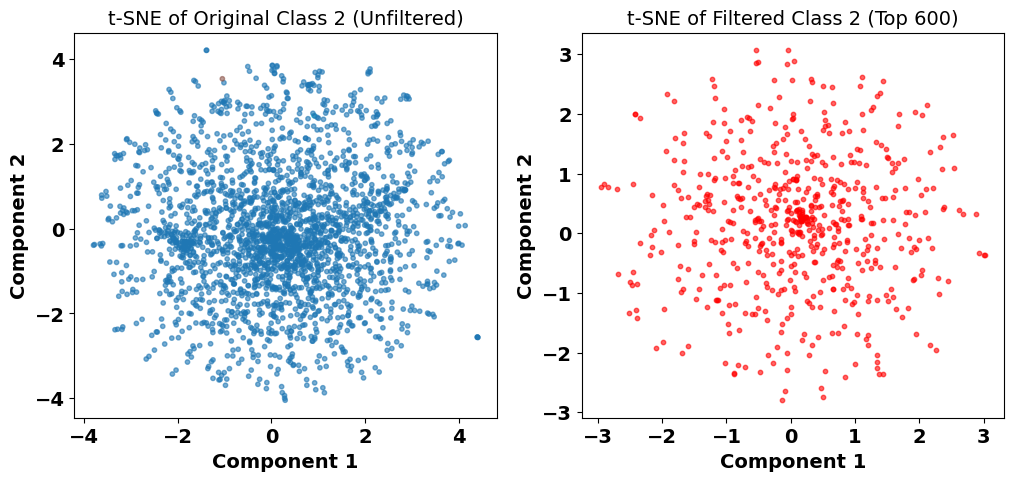

In [ ]:
# from sklearn.manifold import TSNE

# # ------------ Reuse Preprocessed Data ------------
# # Original scaled features (full Class 2)
# X2_all = X2_scaled
# y2_all = class2_df['cluster'].values  # optional: color by cluster

# # Filtered scaled features (top 600)
# X2_filtered = scaler.transform(top600_class2.iloc[:, :-5].values)  # same preprocessing
# y2_filtered = top600_class2['label'].values  # should all be 2

# # ------------ t-SNE Fitting ------------
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

# X2_all_tsne = tsne.fit_transform(X2_all)
# X2_filtered_tsne = tsne.fit_transform(X2_filtered)

# # ------------ Plotting ------------
# plt.figure(figsize=(12, 5))

# # Original
# plt.subplot(1, 2, 1)
# plt.scatter(X2_all_tsne[:, 0], X2_all_tsne[:, 1], c=class2_df['cluster'], cmap='tab10', s=10, alpha=0.6)
# plt.title("t-SNE of Original Class 2 (Unfiltered)", fontsize=14)
# plt.xlabel("Component 1", fontsize = 14, fontweight = "bold")
# plt.ylabel("Component 2", fontsize = 14, fontweight = "bold")
# plt.xticks(fontsize = 14, fontweight = "bold")
# plt.yticks(fontsize = 14, fontweight = "bold")

# # Filtered
# plt.subplot(1, 2, 2)
# plt.scatter(X2_filtered_tsne[:, 0], X2_filtered_tsne[:, 1], c='red', s=10, alpha=0.6)
# plt.title("t-SNE of Filtered Class 2 (Top 600)", fontsize=14)
# plt.xlabel("Component 1", fontsize = 14, fontweight = "bold")
# plt.ylabel("Component 2", fontsize = 14, fontweight = "bold")
# plt.xticks(fontsize = 14, fontweight = "bold")
# plt.yticks(fontsize = 14, fontweight = "bold")

# # plt.tight_layout()
# plt.show()


In [ ]:
import pandas as pd
import numpy as np
import random
from scipy.signal import butter, lfilter
import neurokit2 as nk
from biosppy.signals import ecg
import hashlib
from sklearn.utils import shuffle

# ---------------------- Reusable Functions ---------------------- #

def engzeemod_filter(signal, low_cut=30, high_cut=60, sampling_rate=300):
    nyquist = 0.5 * sampling_rate
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(2, [low, high], btype='bandstop')
    return lfilter(b, a, signal)

def neurokit_filter(signal, sampling_rate=300):
    return nk.ecg_clean(signal, sampling_rate=sampling_rate)

def biosppy_filter(signal, sampling_rate=300):
    out = ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)
    return out['filtered']

def apply_filter(signal, filter_name):
    if filter_name == "NeuroKit":
        return neurokit_filter(signal)
    elif filter_name == "BioSPPy":
        return biosppy_filter(signal)
    elif filter_name == "EngZeeMod":
        return engzeemod_filter(signal)
    return None

def cosine_similarity(a, b):
    dot = np.dot(a, b)
    norm = np.linalg.norm(a) * np.linalg.norm(b)
    return 0 if norm == 0 else dot / norm

def signal_hash(signal):
    signal_str = ','.join([str(round(x, 2)) for x in signal])
    return hashlib.sha256(signal_str.encode()).hexdigest()

# ---------------------- Load Dataset ---------------------- #

csv_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/final_merged_with_best_class2_kmeans.csv"
df = pd.read_csv(csv_path)
signal_cols = [str(i) for i in range(9000)]  # 0 to 8999

# Used hashes from current dataset
used_hashes = set(df[signal_cols].apply(lambda row: signal_hash(row.values.astype(float)), axis=1))

# Extract Class 2
class2_df = df[df['label'] == 2].copy()
signals = class2_df[signal_cols].values.astype(float)
rec_ids = class2_df['record_id'].tolist()

# Augmentation Setup
filters = ["NeuroKit", "BioSPPy", "EngZeeMod"]
target_total = 2000
current_total = len(class2_df)
needed = target_total - current_total

print(f"Class 2 has {current_total} samples, needs {needed} more.")

augmented = []
added_hashes = set()
max_trials = needed * 20  # safety cap

trial = 0
while len(augmented) < needed and trial < max_trials:
    idx = random.randint(0, len(signals) - 1)
    signal = signals[idx]
    rec_id = rec_ids[idx]
    filt = random.choice(filters)

    try:
        aug = apply_filter(signal, filt)
        sim = cosine_similarity(signal, aug)

        if 0.83 <= sim <= 0.98:
            h = signal_hash(aug)
            if h not in used_hashes and h not in added_hashes:
                augmented.append((aug, filt, 2, rec_id, sim))
                used_hashes.add(h)
                added_hashes.add(h)
    except:
        pass
    trial += 1

    if trial % 500 == 0 or len(augmented) == needed:
        print(f"Trials: {trial}, Added: {len(augmented)}")

print(f"Augmented {len(augmented)} additional unique Class 2 signals")

# ---------------------- Merge with Original ---------------------- #

aug_df = pd.DataFrame([row[0] for row in augmented], columns=signal_cols)
aug_df['filter_name'] = [f for _, f, _, _, _ in augmented]
aug_df['label'] = 2
aug_df['original_record_id'] = [rid for _, _, _, rid, _ in augmented]
aug_df['cosine_range'] = ['range' for _ in augmented]  # Optional placeholder
aug_df['record_id'] = [f"Extra_Aug_C2_{i+1}" for i in range(len(augmented))]
aug_df['type'] = 'augmented'

# Reorder and Save
ordered_cols = signal_cols + ['record_id', 'label', 'filter_name', 'original_record_id', 'cosine_range', 'type']
df = pd.concat([df, aug_df], ignore_index=True)[ordered_cols]
df = shuffle(df, random_state=42).reset_index(drop=True)

df.to_csv(csv_path, index=False)

print("\nFinal dataset saved. Class 2 now has:", (df['label'] == 2).sum(), "samples.")



🔄 Class 2 has 600 samples, needs 1400 more.
Trials: 500, Added: 364
Trials: 1000, Added: 627
Trials: 1500, Added: 834
Trials: 2000, Added: 1014
Trials: 2500, Added: 1142
Trials: 3000, Added: 1230
Trials: 3500, Added: 1295
Trials: 4000, Added: 1338
Trials: 4500, Added: 1369
Trials: 5000, Added: 1397
Trials: 5058, Added: 1400

✅ Augmented 1400 additional unique Class 2 signals

✅ Final dataset saved. Class 2 now has: 2000 samples.


In [8]:
import pandas as pd
df = pd.read_csv( "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/final_merged_with_best_class2_kmeans.csv") 
df.head()
print("Unique labels and counts:")
print(df['label'].value_counts())

Unique labels and counts:
label
0    2500
1    2498
3    2246
2    2000
Name: count, dtype: int64


type   augmented  original
label                     
0              0      2500
1           1760       738
2           1400       600
3           1962       284


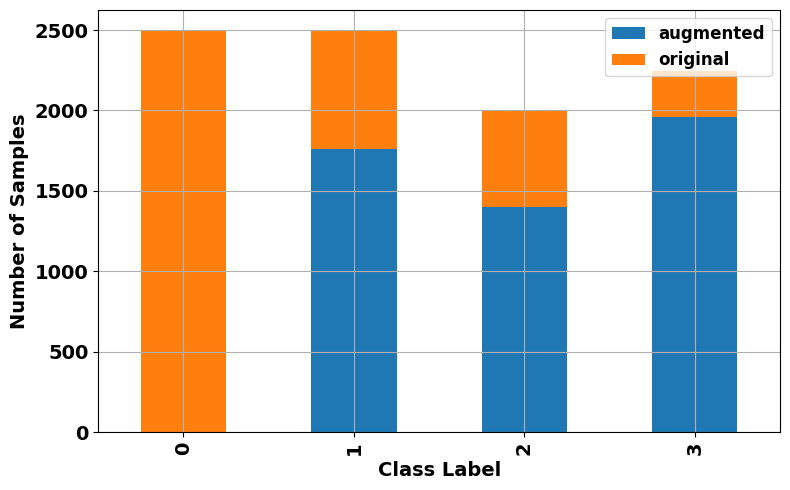

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset (if not already in memory)
df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/final_merged_with_best_class2_kmeans.csv")

# Standardize column names to lowercase for consistency
df.columns = [str(c).lower() for c in df.columns]

# Ensure 'filter_name' and 'label' exist and are clean
if 'filter_name' in df.columns and 'label' in df.columns:
    # Mark original vs augmented
    df['type'] = df['filter_name'].apply(lambda x: 'augmented' if pd.notna(x) else 'original')

    # Count per class
    count_by_type = df.groupby(['label', 'type']).size().unstack(fill_value=0)
    print(count_by_type)

    # Optional: visualize
    count_by_type.plot(kind='bar', stacked=True, figsize=(8, 5))
    # plt.title("Original vs Augmented Samples per Class")
    plt.xlabel("Class Label", fontsize = 14, fontweight = "bold")
    plt.ylabel("Number of Samples", fontsize = 14, fontweight = "bold")
    plt.legend(prop={'size': 12, 'weight': 'bold'})
    plt.xticks(fontsize = 14, fontweight = "bold")
    plt.yticks(fontsize = 14, fontweight = "bold")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Columns 'label' or 'filter_name' not found in the dataset.")


In [10]:
# ---------------------- Cosine Similarity DataFrame for Class 2 ---------------------- #
cosine_data_2 = pd.DataFrame({
    "Cosine Similarity": [round(sim, 4) for _, _, _, _, sim in augmented],
    "Filter": [f for _, f, _, _, _ in augmented],
    "Class": [2 for _ in augmented]  # All are class 2
})


In [11]:
# Combine with other classes if needed
cosine_data_1_3 = pd.DataFrame({
    "Cosine Similarity": [round(sim, 4) for _, _, _, _, sim in augmented_signals],
    "Filter": [f for _, f, _, _, _ in augmented_signals],
    "Class": [lbl for _, _, lbl, _, _ in augmented_signals]
})

# Combine all together
cosine_data = pd.concat([cosine_data_1_3, cosine_data_2], ignore_index=True)


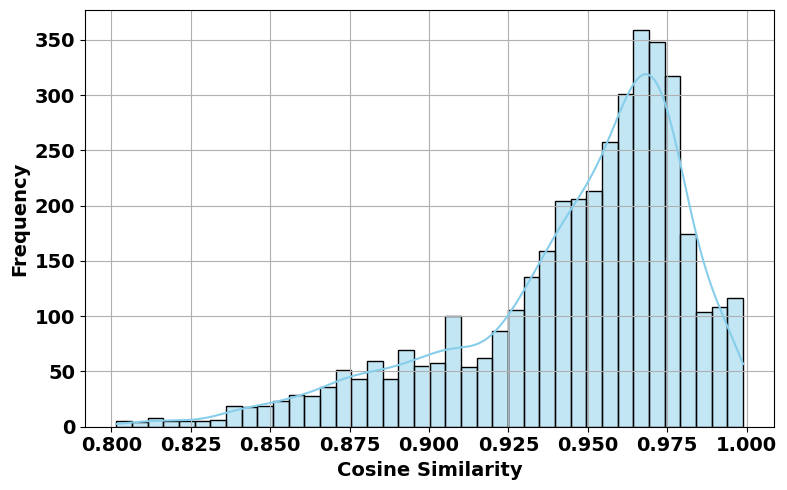

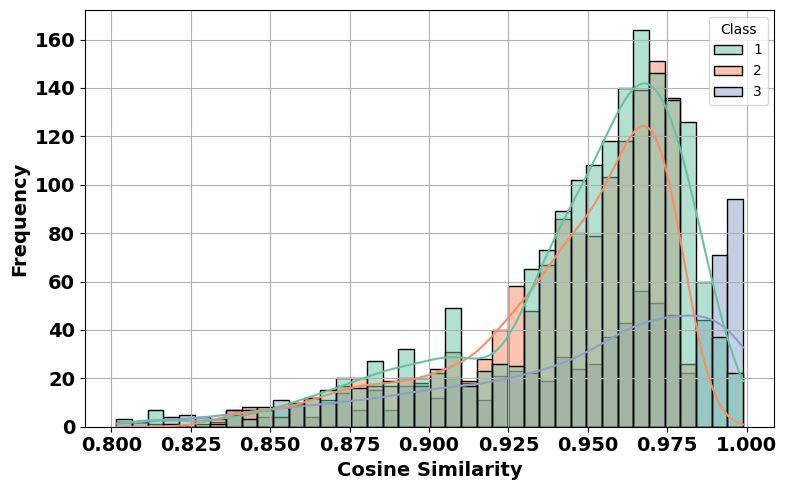

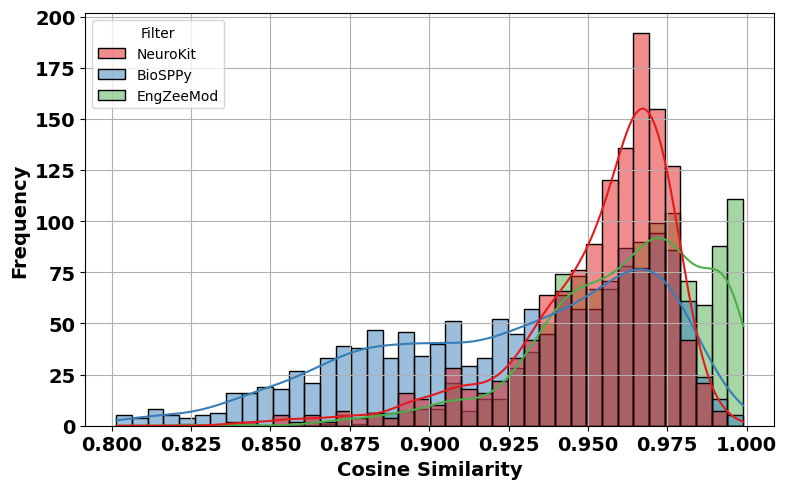

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(cosine_data["Cosine Similarity"], bins=40, kde=True, color='skyblue')
# plt.title("Distribution of Cosine Similarity (All Augmented Signals)")
plt.xlabel("Cosine Similarity", fontsize = 14, fontweight = "bold")
plt.ylabel("Frequency", fontsize = 14, fontweight = "bold")
plt.xticks(fontsize = 14, fontweight = "bold")
plt.yticks(fontsize = 14, fontweight = "bold")
# plt.legend(prop={'size': 14, 'weight': 'bold'})
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=cosine_data, x="Cosine Similarity", hue="Class", bins=40, kde=True, palette="Set2")
# plt.title("Cosine Similarity Distribution by Class")
plt.xlabel("Cosine Similarity", fontsize = 14, fontweight = "bold")
plt.ylabel("Frequency", fontsize = 14, fontweight = "bold")
plt.xticks(fontsize = 14, fontweight = "bold")
plt.yticks(fontsize = 14, fontweight = "bold")
# plt.legend(prop={'size': 14, 'weight': 'bold'})
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=cosine_data, x="Cosine Similarity", hue="Filter", bins=40, kde=True, palette="Set1")
# plt.title("Cosine Similarity Distribution by Filter")
plt.xlabel("Cosine Similarity", fontsize = 14, fontweight = "bold")
plt.ylabel("Frequency", fontsize = 14, fontweight = "bold")
plt.xticks(fontsize = 14, fontweight = "bold")
plt.yticks(fontsize = 14, fontweight = "bold")
# plt.legend(prop={'size': 14, 'weight': 'bold'})
plt.grid(True)
plt.tight_layout()
plt.show()

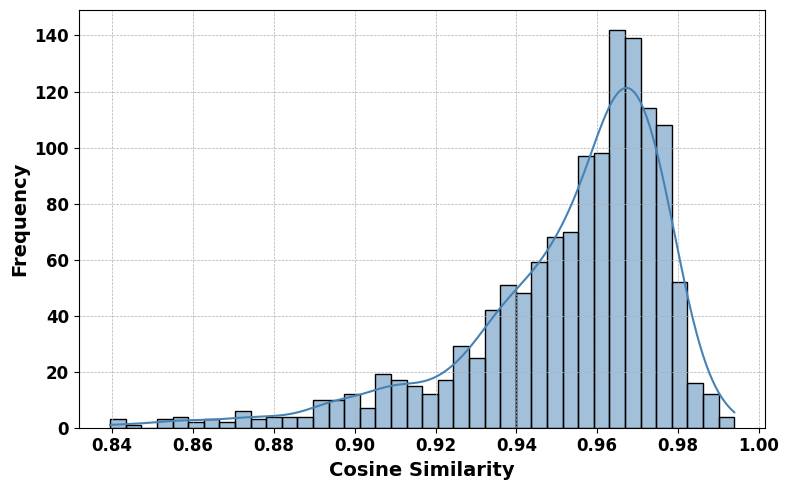

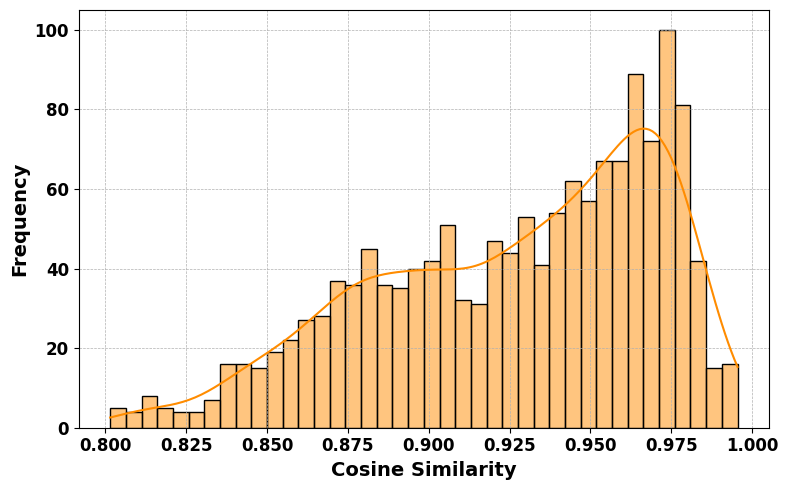

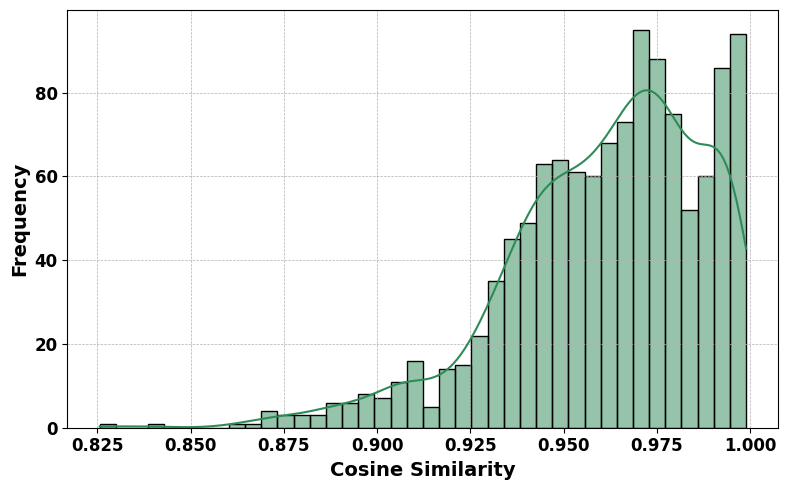

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns



# List of filters and their respective colors
filters = ['NeuroKit', 'BioSPPy', 'EngZeeMod']
colors = ['steelblue', 'darkorange', 'seagreen']

# Create a histogram for each filter
for filt, color in zip(filters, colors):
    subset = cosine_data[cosine_data['Filter'] == filt]

    plt.figure(figsize=(8, 5))
    sns.histplot(data=subset, x="Cosine Similarity", bins=40, kde=True, color=color)

    plt.xlabel("Cosine Similarity", fontsize=14, fontweight="bold")
    plt.ylabel("Frequency", fontsize=14, fontweight="bold")
    # plt.title(f"Cosine Similarity Distribution - {filt}", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=12, fontweight="bold")
    plt.yticks(fontsize=12, fontweight="bold")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [5]:
import pandas as pd

# --- Configuration ---
csv_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation with 7k+ Samples/FYP Keras/Saved_Splits/X_test.csv" # Replace with your CSV path
label_column = "label"
record_id_column = "record_id"

# --- Load Dataset ---
df = pd.read_csv(csv_path)

# --- Input: Record ID ---
record_id = input("Enter the Record ID you want to view/update: ").strip()

# --- Find Matching Row ---
matched_row = df[df[record_id_column].astype(str) == record_id]

if matched_row.empty:
    print("❌ No record found with that Record ID.")
else:
    print("\n✅ Record Found:")
    print(matched_row)

    # --- Ask if user wants to update label ---
    update = input("\nDo you want to change the label of this record? (yes/no): ").strip().lower()

    if update in ['yes', 'y']:
        try:
            new_label = int(input("Enter the new label (0, 1, 2, or 3): ").strip())
            if new_label not in [0, 1, 2, 3]:
                print("❌ Invalid label. Label must be 0, 1, 2, or 3.")
            else:
                # Update the label
                df.loc[df[record_id_column].astype(str) == record_id, label_column] = new_label
                df.to_csv(csv_path, index=False)
                print("\n✅ Label updated successfully.")
                
                # Show updated row
                updated_row = df[df[record_id_column].astype(str) == record_id]
                print("\n🔁 Updated Record:")
                print(updated_row)
        except ValueError:
            print("❌ Invalid input. Please enter an integer label.")
    else:
        print("ℹ️ No changes made to the label.")


TypeError: 'str' object is not callable

In [10]:
df['label'].value_counts()

label
1    2500
0    2493
3    2247
2    2004
Name: count, dtype: int64

In [30]:

import pandas as pd

# --- Configuration ---
df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Research_Paper_Set.csv")
df.head(50)

,0,1,2,3,4,5,6,7,8,9,...,8995,8996,8997,8998,8999,Record_ID,Label,original_record_id,filter_name,cosine_range
0,272.000000,341.000000,419.000000,499.000000,565.000000,604.000000,619.000000,647.000000,660.000000,665.000000,...,-10.000000,-19.000000,-26.000000,-28.000000,-29.000000,A00427,2,A00427,original,NaN
1,-609.000000,-722.000000,-761.000000,-705.000000,-563.000000,-369.000000,-166.000000,0.000000,98.000000,128.000000,...,39.000000,41.000000,44.000000,46.000000,48.000000,A00431,2,A00431,original,NaN
2,433.000000,518.000000,606.000000,696.000000,774.000000,792.000000,797.000000,795.000000,779.000000,763.000000,...,-62.000000,-59.000000,-54.000000,-44.000000,-35.000000,A00542,1,A00542,original,NaN
3,-73.000000,-90.000000,-107.000000,-115.000000,-119.000000,-122.000000,-125.000000,-127.000000,-127.000000,-127.000000,...,9.000000,7.000000,5.000000,3.000000,2.000000,A00545,2,A00545,original,NaN
4,11.000000,11.000000,12.000000,14.000000,16.000000,21.000000,27.000000,35.000000,44.000000,51.000000,...,57.000000,54.000000,47.000000,26.000000,13.000000,A00559,2,A00559,original,NaN
5,88.159175,155.949995,221.104858,280.737289,332.376960,374.719693,407.849678,432.933920,450.389163,461.715487,...,57.558475,53.626972,51.487553,50.733448,50.730258,Augmented_1,2,A00427,NeuroKit,89–95%
6,4.542256,80.550098,153.368210,219.417099,274.970631,317.145664,345.099547,360.604482,367.475676,370.046335,...,14.923071,5.402945,-0.667908,-2.884390,-2.530849,Augmented_1,2,A00427,BioSPPy,89–95%
7,173.793183,125.827879,218.320663,364.882317,479.893582,546.915699,593.730950,651.034586,675.657709,678.341448,...,3.059577,-8.492197,-18.037315,-23.369005,-28.050369,Augmented_1,2,A00427,EngZeeMod,89–95%
8,42.935396,46.747275,67.087112,114.232865,189.851381,287.609508,394.896313,496.517532,579.834457,638.180600,...,-31.858638,-33.901000,-36.177020,-38.613994,-41.134039,Augmented_1,2,A00431,NeuroKit,83–88%
9,-16.077288,-127.723908,-179.860386,-137.312277,-2.249770,189.579464,386.399692,542.373733,633.562630,661.773775,...,-5.481100,-4.382239,-3.288901,-2.036136,-0.638649,Augmented_1,2,A00431,BioSPPy,89–95%


In [ ]:
import pandas as pd
import numpy as np
import random
import hashlib
from scipy.signal import butter, lfilter
import neurokit2 as nk
from biosppy.signals import ecg
from sklearn.utils import shuffle

# ---------------------- Signal Processing ---------------------- #
def engzeemod_filter(signal, low_cut=30, high_cut=60, sampling_rate=300):
    nyquist = 0.5 * sampling_rate
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(2, [low, high], btype='bandstop')
    return lfilter(b, a, signal)

def neurokit_filter(signal, sampling_rate=300):
    return nk.ecg_clean(signal, sampling_rate=sampling_rate)

def biosppy_filter(signal, sampling_rate=300):
    out = ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)
    return out['filtered']

def apply_filter(signal, filter_name):
    if filter_name == "NeuroKit":
        return neurokit_filter(signal)
    elif filter_name == "BioSPPy":
        return biosppy_filter(signal)
    elif filter_name == "EngZeeMod":
        return engzeemod_filter(signal)
    return None

def cosine_similarity(signal_a, signal_b):
    signal_a = np.asarray(signal_a)
    signal_b = np.asarray(signal_b)
    dot_product = np.dot(signal_a, signal_b)
    norm_a = np.linalg.norm(signal_a)
    norm_b = np.linalg.norm(signal_b)
    return 0.0 if norm_a == 0 or norm_b == 0 else dot_product / (norm_a * norm_b)

def signal_hash(signal):
    signal_str = ','.join([str(round(x, 2)) for x in signal])
    return hashlib.sha256(signal_str.encode()).hexdigest()

# ---------------------- Load Dataset ---------------------- #
file_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/ecg_signals_fixed_9000/ecg_signals_fixed_9000_encoded.csv"  # <-- Update if needed
df = pd.read_csv(file_path)

signal_len = 9000
cosine_ranges = [(0.83, 0.88), (0.89, 0.95), (0.96, 0.98)]
filters = ["NeuroKit", "BioSPPy", "EngZeeMod"]

class_1_df = df[df['Label'] == 1].reset_index(drop=True)
selected_df = class_1_df.sample(n=5, random_state=42).copy()

used_hashes = set()
augmented_rows = []

# ---------------------- Augment 5 Signals × 3 Ranges × 3 Filters ---------------------- #
for _, row in selected_df.iterrows():
    original_signal = row.iloc[:signal_len].values.astype(float)
    original_id = row['Record_ID']

    for (low, high) in cosine_ranges:
        cosine_range_label = f"{int(low * 100)}–{int(high * 100)}%"

        for f_name in filters:
            try:
                filtered_signal = apply_filter(original_signal, f_name)
                sim = cosine_similarity(original_signal, filtered_signal)
            except Exception as e:
                continue

            if low <= sim <= high:
                sig_hash = signal_hash(filtered_signal)
                if sig_hash in used_hashes:
                    continue
                used_hashes.add(sig_hash)

                new_row = row.copy()
                for i in range(signal_len):
                    new_row[str(i)] = filtered_signal[i]
                new_row['Record_ID'] = f"Augmented_{len(augmented_rows)+1}"
                new_row['original_record_id'] = original_id
                new_row['filter_name'] = f_name
                new_row['cosine_range'] = cosine_range_label
                augmented_rows.append(new_row)
            else:
                print(f" Skipped: {f_name} for {original_id} in range {cosine_range_label} | Sim: {sim:.4f}")

# ---------------------- Save Results ---------------------- #
augmented_df = pd.DataFrame(augmented_rows)

# Ensure all expected columns exist
for col in ['filter_name', 'original_record_id', 'cosine_range']:
    if col not in augmented_df.columns:
        augmented_df[col] = None

# Check and save exactly 45 signals
if len(augmented_df) == 45:
    augmented_df.to_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Research_Paper_Set.csv", index=False)
    print(" 45 augmented signals saved to 'Research_Paper_Set.csv'")
else:
    print(f"Only {len(augmented_df)} augmentations generated. Expected 45. Some combinations may have failed cosine similarity check.")


⛔ Skipped: NeuroKit for A02900 in range 83–88% | Sim: 0.9699
⛔ Skipped: BioSPPy for A02900 in range 83–88% | Sim: 0.9684
⛔ Skipped: EngZeeMod for A02900 in range 83–88% | Sim: 0.9891
⛔ Skipped: NeuroKit for A02900 in range 89–95% | Sim: 0.9699
⛔ Skipped: BioSPPy for A02900 in range 89–95% | Sim: 0.9684
⛔ Skipped: EngZeeMod for A02900 in range 89–95% | Sim: 0.9891
⛔ Skipped: EngZeeMod for A02900 in range 96–98% | Sim: 0.9891
⛔ Skipped: NeuroKit for A03358 in range 83–88% | Sim: 0.9624
⛔ Skipped: BioSPPy for A03358 in range 83–88% | Sim: 0.9795
⛔ Skipped: EngZeeMod for A03358 in range 83–88% | Sim: 0.9095
⛔ Skipped: NeuroKit for A03358 in range 89–95% | Sim: 0.9624
⛔ Skipped: BioSPPy for A03358 in range 89–95% | Sim: 0.9795
⛔ Skipped: EngZeeMod for A03358 in range 96–98% | Sim: 0.9095
⛔ Skipped: NeuroKit for A02375 in range 83–88% | Sim: 0.9703
⛔ Skipped: BioSPPy for A02375 in range 83–88% | Sim: 0.9112
⛔ Skipped: EngZeeMod for A02375 in range 83–88% | Sim: 0.9635
⛔ Skipped: NeuroKit for

In [ ]:
import pandas as pd
import numpy as np
import hashlib
from scipy.signal import butter, lfilter
import neurokit2 as nk
from biosppy.signals import ecg
from sklearn.utils import shuffle

# ---------------------- Signal Processing ---------------------- #
def engzeemod_filter(signal, low_cut=30, high_cut=60, sampling_rate=300):
    nyquist = 0.5 * sampling_rate
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(2, [low, high], btype='bandstop')
    return lfilter(b, a, signal)

def neurokit_filter(signal, sampling_rate=300):
    return nk.ecg_clean(signal, sampling_rate=sampling_rate)

def biosppy_filter(signal, sampling_rate=300):
    out = ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)
    return out['filtered']

def apply_filter(signal, filter_name):
    if filter_name == "NeuroKit":
        return neurokit_filter(signal)
    elif filter_name == "BioSPPy":
        return biosppy_filter(signal)
    elif filter_name == "EngZeeMod":
        return engzeemod_filter(signal)
    return None

def cosine_similarity(signal_a, signal_b):
    signal_a = np.asarray(signal_a)
    signal_b = np.asarray(signal_b)
    dot_product = np.dot(signal_a, signal_b)
    norm_a = np.linalg.norm(signal_a)
    norm_b = np.linalg.norm(signal_b)
    return 0.0 if norm_a == 0 or norm_b == 0 else dot_product / (norm_a * norm_b)

def signal_hash(signal):
    signal_str = ','.join([str(round(x, 2)) for x in signal])
    return hashlib.sha256(signal_str.encode()).hexdigest()

# ---------------------- Load Dataset ---------------------- #
file_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/ecg_signals_fixed_9000/ecg_signals_fixed_9000_encoded.csv"
df = pd.read_csv(file_path)
df = df[df['Label'].isin([1, 2, 3])].reset_index(drop=True)

signal_len = 9000
cosine_ranges = [(0.83, 0.88), (0.89, 0.95)]
filters = ["NeuroKit", "BioSPPy", "EngZeeMod"]

used_hashes = set()
signal_scores = []
augmented_rows = []
original_rows = []

# ---------------------- Analyze All Signals ---------------------- #
for _, row in df.iterrows():
    original_signal = row.iloc[:signal_len].values.astype(float)
    original_id = row['Record_ID']
    label = row['Label']
    success_count = 0
    local_augments = []

    for (low, high) in cosine_ranges:
        cosine_range_label = f"{int(low * 100)}–{int(high * 100)}%"
        for f_name in filters:
            try:
                filtered = apply_filter(original_signal, f_name)
                sim = cosine_similarity(original_signal, filtered)
            except Exception:
                continue
            if low <= sim <= high:
                success_count += 1
                sig_hash = signal_hash(filtered)
                if sig_hash in used_hashes:
                    continue
                used_hashes.add(sig_hash)

                new_row = row.copy()
                for i in range(signal_len):
                    new_row[str(i)] = filtered[i]
                new_row['Record_ID'] = f"Augmented_{len(augmented_rows)+1}"
                new_row['original_record_id'] = original_id
                new_row['filter_name'] = f_name
                new_row['cosine_range'] = cosine_range_label
                local_augments.append(new_row)

    signal_scores.append((original_id, label, success_count, local_augments))

# ---------------------- Select Top 5 Signals ---------------------- #
top_signals = sorted(signal_scores, key=lambda x: x[2], reverse=True)[:5]

for original_id, label, count, augments in top_signals:
    # Save the original row
    orig_row = df[df['Record_ID'] == original_id].copy()
    orig_row['original_record_id'] = original_id
    orig_row['filter_name'] = "original"
    orig_row['cosine_range'] = "N/A"
    original_rows.append(orig_row.iloc[0])

    # Save augmented versions
    augmented_rows.extend(augments)

# ---------------------- Combine and Save ---------------------- #
final_df = pd.DataFrame([*original_rows] + augmented_rows)
output_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Research_Paper_Set.csv"
final_df.to_csv(output_path, index=False)

print(f"Saved original + augmented versions of top 5 signals to:\n{output_path}")


✅ Saved original + augmented versions of top 5 signals to:
/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Research_Paper_Set.csv


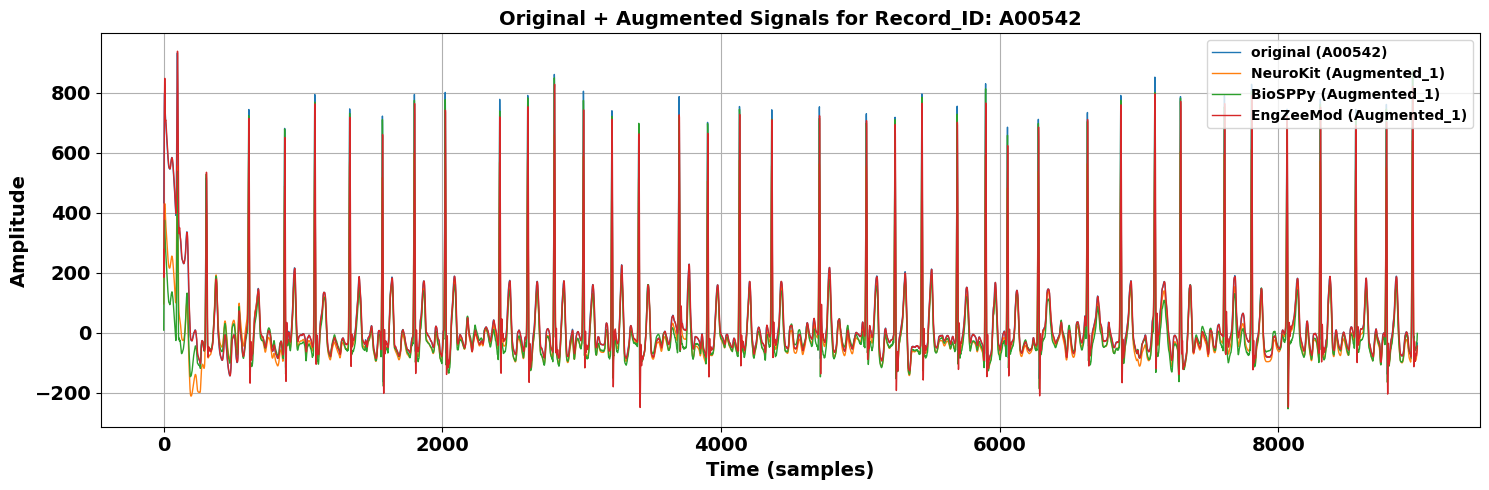

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------- Load Dataset ---------------------- #
csv_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Research_Paper_Set.csv"
df = pd.read_csv(csv_path)

signal_len = 9000

# ---------------------- Plot Function ---------------------- #
def plot_augmented_versions(record_id):
    # Determine if input is original or augmented
    if record_id.startswith("Augmented_"):
        orig_id = df[df['Record_ID'] == record_id]['original_record_id'].values[0]
    else:
        orig_id = record_id

    # Get original + all augmented for this signal
    subset = df[df['original_record_id'] == orig_id]

    if subset.empty:
        print(f"No entries found for Record_ID: {record_id}")
        return

    plt.figure(figsize=(15, 5))

    for _, row in subset.iterrows():
        signal = row.iloc[:signal_len].values.astype(float)
        label = row['filter_name']
        rec_id = row['Record_ID']
        plt.plot(signal, label=f"{label} ({rec_id})", linewidth=1)

    plt.title(f"Original + Augmented Signals for Record_ID: {orig_id}", fontsize=14, fontweight='bold')
    plt.xlabel("Time (samples)", fontsize=14, fontweight='bold')
    plt.ylabel("Amplitude", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.legend(fontsize=12, loc='upper right', frameon=True, prop={'weight': 'bold'})
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# ---------------------- Example Usage ---------------------- #
plot_augmented_versions("A00542")  # Change this to your desired Record_ID


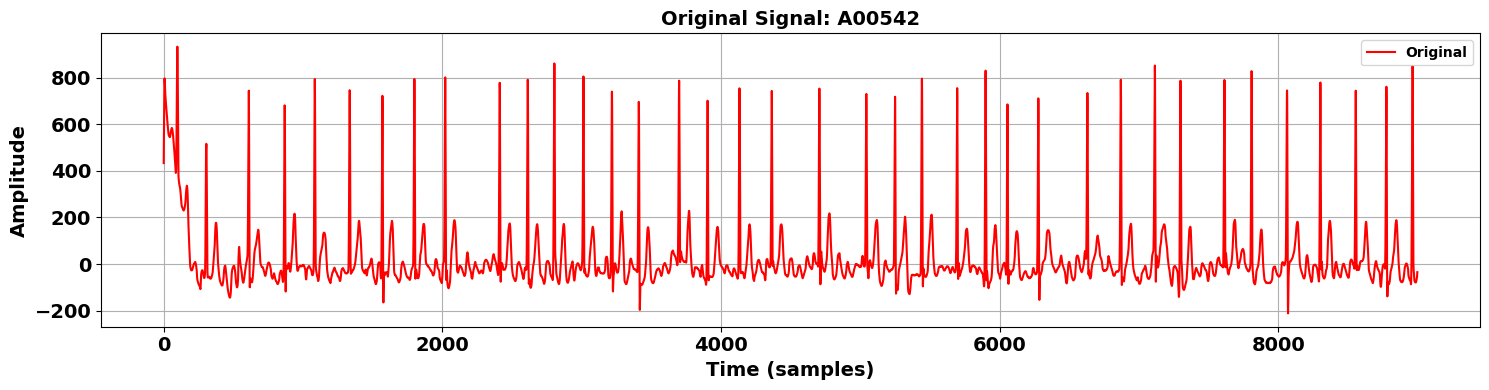

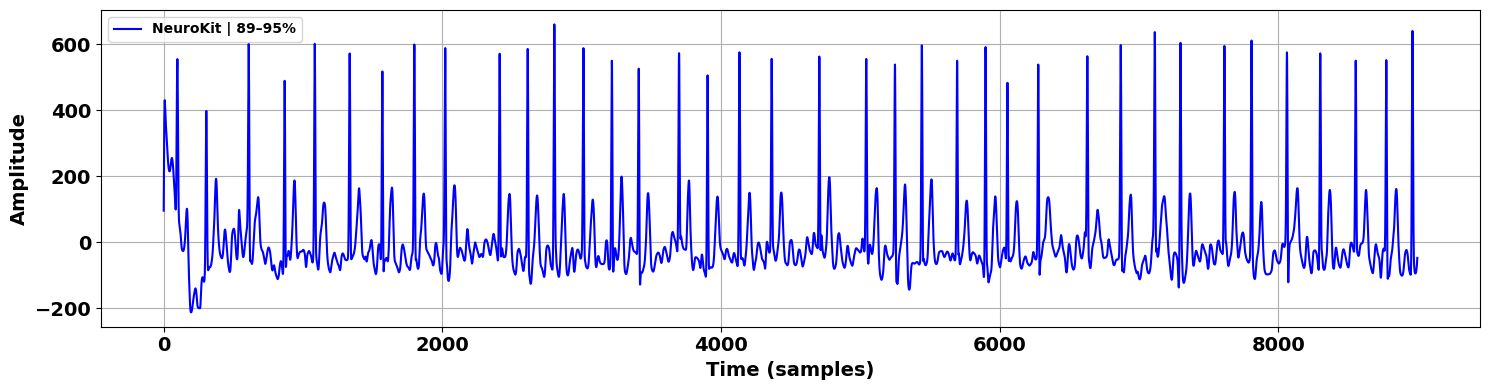

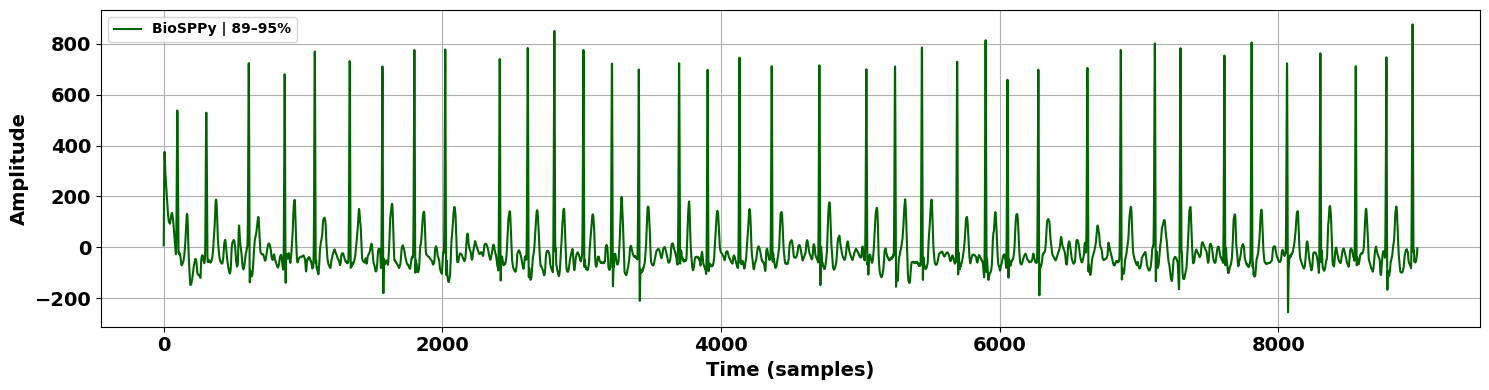

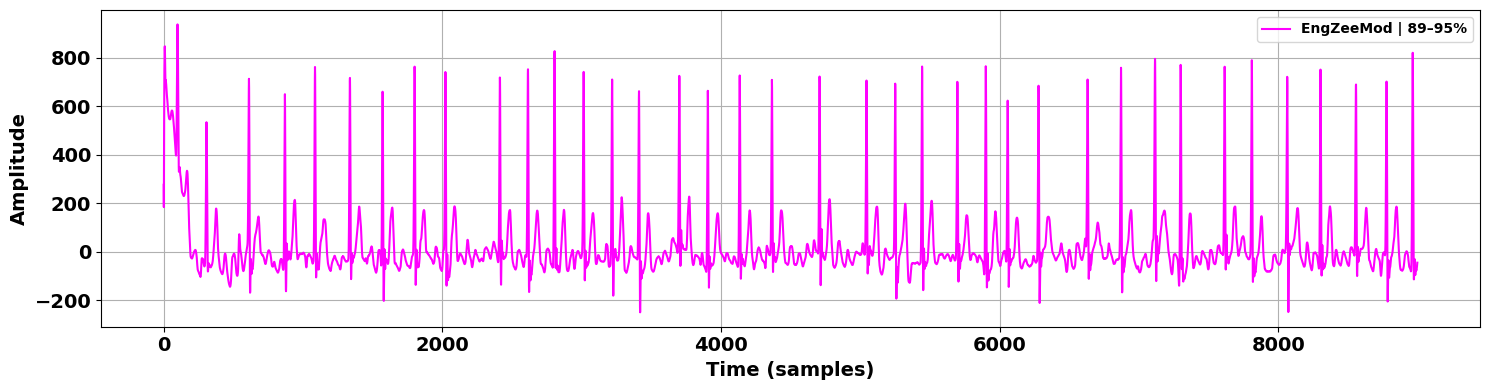

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------- Load Dataset ---------------------- #
csv_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Last datasets/Research_Paper_Set.csv"
df = pd.read_csv(csv_path)

signal_len = 9000

# Define distinct vivid colors
vivid_colors = ['red', 'blue', 'darkgreen', 'magenta', 'orange', 'teal']

# ---------------------- Plotting Function ---------------------- #
def plot_original_and_augmented(record_id):
    # Get the original_record_id if an augmented signal is passed
    if record_id.startswith("Augmented_"):
        record_id = df[df['Record_ID'] == record_id]['original_record_id'].values[0]

    # Extract original + augmentations
    subset = df[df['original_record_id'] == record_id]

    if subset.empty:
        print(f" No signals found for Record_ID: {record_id}")
        return

    # 1. Plot original signal
    original = subset[subset['filter_name'] == "original"].iloc[0]
    signal = original.iloc[:signal_len].values.astype(float)

    plt.figure(figsize=(15, 4))
    plt.plot(signal, label="Original", color=vivid_colors[0], linewidth=1.5)
    plt.title(f"Original Signal: {record_id}", fontsize=14, fontweight='bold')
    plt.xlabel("Time (samples)", fontsize=14, fontweight='bold')
    plt.ylabel("Amplitude", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.legend(fontsize=12, prop={'weight': 'bold'})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Plot each augmented signal in its own figure
    augmented_signals = subset[subset['filter_name'] != "original"]

    for i, (_, row) in enumerate(augmented_signals.iterrows()):
        signal = row.iloc[:signal_len].values.astype(float)
        aug_id = row['Record_ID']
        f_name = row['filter_name']
        cos_range = row['cosine_range']
        color = vivid_colors[(i + 1) % len(vivid_colors)]  # Use different color per figure

        plt.figure(figsize=(15, 4))
        plt.plot(signal, label=f"{f_name} | {cos_range}", color=color, linewidth=1.5)
        # plt.title(f"Augmented Signal: {aug_id}", fontsize=14, fontweight='bold')
        plt.xlabel("Time (samples)", fontsize=14, fontweight='bold')
        plt.ylabel("Amplitude", fontsize=14, fontweight='bold')
        plt.xticks(fontsize=14, fontweight='bold')
        plt.yticks(fontsize=14, fontweight='bold')
        plt.legend(fontsize=12, prop={'weight': 'bold'})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ---------------------- Example Usage ---------------------- #
plot_original_and_augmented("A00542")  # Replace with your Record_ID


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import json

# ==== STEP 1: Prepare your y_train ====
# If y_train is one-hot encoded, convert to class labels
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = np.argmax(y_train, axis=1)
else:
    y_train_labels = y_train  # Already in label form

# ==== STEP 2: Compute class weights ====
classes = np.unique(y_train_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels)

# Convert to TensorFlow tensor
class_weights_tensor = tf.constant(class_weights_array, dtype=tf.float32)

# Optional: print for verification
print(" Computed class weights:")
for i, weight in enumerate(class_weights_array):
    print(f"Class {i}: {weight:.4f}")